In [1]:
import tweepy
import re
import pymongo
from pymongo import MongoClient
import json
import pandas as pd
import emoji
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
import time

### ทำการดึงข้อมูลมาจาก mongodb แล้วมาทำ dataframe

In [2]:
client = MongoClient('localhost',27017)
db = client.tweet_db

In [3]:
db = client['tweet_db']

In [4]:
tweet_data = db.tweet_collectionV3

In [5]:
df = pd.DataFrame(list(tweet_data.find()))
df.head()

,_id,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
0,5e7411b70e6efd86094de16e,056Chompuu,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,7,/0319YouthWithLisa,Fri Mar 20 00:43:29 +0000 2020
1,5e7411b70e6efd86094de16f,LolaAfdila,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,176,,Fri Mar 20 00:43:27 +0000 2020
2,5e7411b70e6efd86094de170,Samseeyah10,เดี๋ยวๆคู่นี้ก็ไม่ได้ทีมเดียวกันนะแต่ตัวติดกัน...,10,15,14,/0319YouthWithLalisa/LalisaManobal/Blackpink,Fri Mar 20 00:43:10 +0000 2020
3,5e7411b70e6efd86094de171,nongggjj9,Track List หลุดมาอีกรอบแล้วค่ะ อันนี้น่าจะดูเป...,71,102,367,,Fri Mar 20 00:43:09 +0000 2020
4,5e7411b70e6efd86094de172,OWongkamsak,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,57,,Fri Mar 20 00:42:43 +0000 2020


In [6]:
df = df.drop(['_id'], axis=1)

In [7]:
df.head()

,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
0,056Chompuu,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,7,/0319YouthWithLisa,Fri Mar 20 00:43:29 +0000 2020
1,LolaAfdila,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,176,,Fri Mar 20 00:43:27 +0000 2020
2,Samseeyah10,เดี๋ยวๆคู่นี้ก็ไม่ได้ทีมเดียวกันนะแต่ตัวติดกัน...,10,15,14,/0319YouthWithLalisa/LalisaManobal/Blackpink,Fri Mar 20 00:43:10 +0000 2020
3,nongggjj9,Track List หลุดมาอีกรอบแล้วค่ะ อันนี้น่าจะดูเป...,71,102,367,,Fri Mar 20 00:43:09 +0000 2020
4,OWongkamsak,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,57,,Fri Mar 20 00:42:43 +0000 2020


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46693 entries, 0 to 46692
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         46693 non-null  object
 1   full_text       46693 non-null  object
 2   favorite_count  46693 non-null  int64 
 3   retweet_count   46693 non-null  int64 
 4   follower_count  46693 non-null  int64 
 5   all_hashtag     46693 non-null  object
 6   time            46693 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.5+ MB


### ช่วงการ cleaning อีกรอบ
เนือกจาก เราใช้ .info() ดูข้อมูลที่เราได้มา พบว่าในส่วนของข้อมูล hashtags นั้นไม่มีค่า non <br/>
แต่เราเห็นว่าในส่วนนี้ข้อมูลมันไม่สมบูรณ์เลยเอาออกครับ และเช็ค full text ที่ user เดียวกันซ้ำอีกรอบ

In [9]:
df.duplicated(['user_id', 'full_text']).sum()

44

In [10]:
df.drop_duplicates(['user_id', 'full_text'], inplace=True)

In [11]:
df = df[df['all_hashtag'].map(lambda d: len(d)) > 0]

In [12]:
df

,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
0,056Chompuu,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,7,/0319YouthWithLisa,Fri Mar 20 00:43:29 +0000 2020
2,Samseeyah10,เดี๋ยวๆคู่นี้ก็ไม่ได้ทีมเดียวกันนะแต่ตัวติดกัน...,10,15,14,/0319YouthWithLalisa/LalisaManobal/Blackpink,Fri Mar 20 00:43:10 +0000 2020
9,lalali_lalaloy,19320 엑스포츠 news. #BLACKPINK #LISA ความงดงามที่...,503,583,150,/BLACKPINK/LISA,Fri Mar 20 00:41:42 +0000 2020
10,14113_,ชั้นล่ะขำแม่ อต. พ่กนางจะหวีดสำเนียงไอ่ลูกยันส...,478,595,15,/0319YouthWithLalisa/LalisaManobal,Fri Mar 20 00:41:41 +0000 2020
11,Lisabonus2,ลิซ่าให้กำลังใจเด็กฝึก ถ้าคุณสู้ต่อไป ไม่ท้อถอ...,1872,2224,53,/0319YouthWithLisa/YouthWithYouEP03/BLACKPINK,Fri Mar 20 00:41:31 +0000 2020
...,...,...,...,...,...,...,...
46679,BxxBxx95,เราทำภาพประกอบ #NoCPTPP #คัดค้านCPTPP สรุปแบบท...,11098,60480,58,/NoCPTPP/คัดค้านCPTPP,Mon Jun 08 01:23:21 +0000 2020
46682,BxxBxx95,สรุป #NoCPTPP แบบสรุปแล้วสรุปอีก เพราะข้อมูลมั...,7603,43848,58,/NoCPTPP,Mon Jun 08 01:22:32 +0000 2020
46686,eieityu,เราทำภาพประกอบ #NoCPTPP #คัดค้านCPTPP สรุปแบบท...,11098,60480,58,/NoCPTPP/คัดค้านCPTPP,Mon Jun 08 01:22:10 +0000 2020
46690,saitan1997,เราทำภาพประกอบ #NoCPTPP #คัดค้านCPTPP สรุปแบบท...,11098,60480,1,/NoCPTPP/คัดค้านCPTPP,Mon Jun 08 01:21:53 +0000 2020


จากข้อมูลทั้งหมด 14,296 ในตอนนี้แรก สามารถใช้ได้จริง 9173

In [13]:
df.describe()

,favorite_count,retweet_count,follower_count
count,27490.000000,27490.000000,27490.000000
mean,1170.298145,5377.320662,444.503238
std,1963.352670,11322.487528,5238.614301
min,0.000000,0.000000,0.000000
25%,254.000000,599.750000,21.000000
50%,478.000000,1684.000000,75.000000
75%,1609.000000,3256.000000,195.000000
max,38336.000000,60480.000000,378113.000000


เราใช้ pythainlp เข้ามาช่วยจัดการในข้อมูลที่เป็นภาษาไทย และกรองข้อมูลออกมาดู

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt 

In [15]:
def slash_tokenize(d):  
    result = d.split("/")
    result = list(filter(None, result))
    return result

def cleanText(text):
    text = str(text)
    text = re.sub('[^ก-๙]','',text)
    stop_word = list(thai_stopwords())
    sentence = word_tokenize(text , engine='newmm')
    result = [word for word in sentence if word not in stop_word and " " not in word]
    return " /".join(result)

def tokenize(d):  
    result = d.split("/")
    result = list(filter(None, result))
    return result

new_text = []
for txt in df["full_text"]:
    new_text.append(cleanText(txt))

hastag_data = df["all_hashtag"].dropna()
vectorizer = CountVectorizer(tokenizer=slash_tokenize)
transformed_data = vectorizer.fit_transform(hastag_data)
hash_tag_cnt_df= pd.DataFrame(columns = ['word', 'count']) 
hash_tag_cnt_df['word'] = vectorizer.get_feature_names()
hash_tag_cnt_df['count'] = np.ravel(transformed_data.sum(axis=0))
hash_tag_cnt_df.sort_values(by=['count'], ascending=False).head(20)

,word,count
154,nocptpp,12641
196,saveวันเฉลิม,6533
25,blackpink,6100
269,คัดค้านcptpp,5891
3,0319youthwithlisa,4691
245,youthwithyouep03,3675
404,ยกเลิก112,2742
200,saveหมู่อาร์ม,2725
23,blacklivesmatter,2553
202,saveหาดม่วงงาม,2533


นี้จะเป็น hashtags ที่อยู่กับ tweet ที่เกี่ยวข้องทั้งหมดซึ่ง ในช่วงนี้นั้นมีรายการหนึ่งพึ่งจัดขึ้น <br/>
ทำให้ 0319youthwithlisa และ youthwithyouep03 ที่เป็นเหตุการณ์ในรายการ มีการทวิตขึ้นมาด้วย <br/>
และอีกส่วนจะเป็นคำที่พบใน full_text ของทวิตมากที่สุด

In [16]:
vectorizer = CountVectorizer(tokenizer=tokenize)
transformed_data = vectorizer.fit_transform(new_text)
count_data = zip(vectorizer.get_feature_names(), np.ravel(transformed_data.sum(axis=0)))
keyword_df2 = pd.DataFrame(columns = ['word', 'count'])
keyword_df2['word'] = vectorizer.get_feature_names()
keyword_df2['count'] = np.ravel(transformed_data.sum(axis=0))   
keyword_df2.sort_values(by=['count'], ascending=False).head(20)

,word,count
2750,อย่า,13537
3016,เฉลิม,9559
1117,ทำ,6893
2185,ลิ,5972
754,ซ่า,5135
3262,เรื่อง,5039
1220,นะคะ,4668
429,คัดค้าน,4479
3386,เอาเปรียบ,4286
290,คน,4152


ทำการสร้าง wordclound ในการทำ visualization เพื่อแสดงถึงสิ่งที่ทำมาให้เป็นภาพ

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


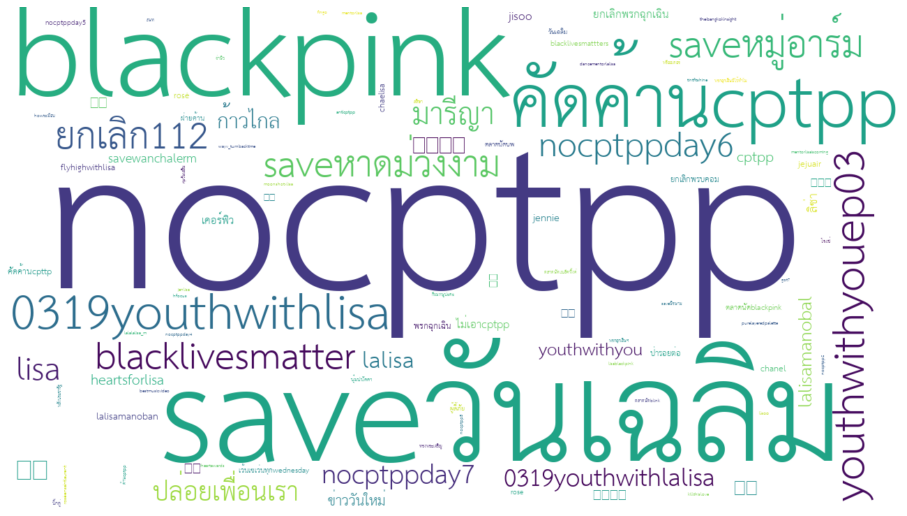

In [17]:
word_dict = {}
for i in range(0,len(keyword_df2)):
    try:
        word_dict[hash_tag_cnt_df.word[i]]= hash_tag_cnt_df['count'][i]
    except:
        pass
wordcloud = WordCloud(font_path='/content/THSarabunNew.ttf',background_color ='white',
                      max_words=100,width=1280, height=720).fit_words(word_dict)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


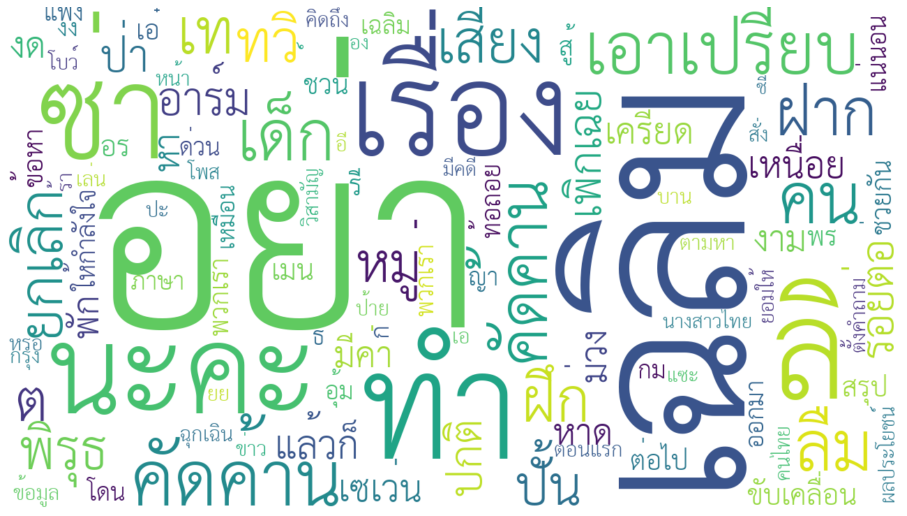

In [18]:
word_dict = {}
for i in range(0,len(keyword_df2)):
    word_dict[keyword_df2.word[i]]= keyword_df2['count'][i]
wordcloud = WordCloud(font_path='/content/THSarabunNew.ttf',background_color ='white',
                      max_words=100,width=1280, height=720).fit_words(word_dict).fit_words(word_dict)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### เลือก Column ที่ต้องการแล้วลองมาเรียงลำดับเพื่อดูยอดสูงสุดกัน

In [19]:
df.drop_duplicates("full_text").sort_values(by=['favorite_count'], ascending=False).head(10)[['full_text','favorite_count']]

,full_text,favorite_count
1521,พร้อมเข้าสู่ยุค 5G กับ AIS 5G ที่ดีที่สุดในไทย...,38336
23778,ก็อย่างว่า การทำนาเขาไม่ได้มีไว้ทำบนดิน เขามีไ...,15446
23777,สุดท้ายจะกลายเป็นเรา ที่ทำงานมาทั้งหมดก็เพื่อแ...,11570
22810,เราทำภาพประกอบ #NoCPTPP #คัดค้านCPTPP สรุปแบบท...,11096
20553,แถลงการณ์สโมสรนิสิตรัฐศาสตร์ จุฬาลงกรณ์มหาวิทย...,9542
14566,ทุกคนนนน #มารีญา เลือกดื่มน้ำ อควาฟิน่า สนับสน...,8165
22896,สรุป #NoCPTPP แบบสรุปแล้วสรุปอีก เพราะข้อมูลมั...,7603
17959,#saveวันเฉลิม เขาไม่ใช่คนแรกที่ตกเป็นเหยื่อการ...,6792
6651,กุตายไปแร้วววววในจุดนี้ ฮึกก ลลิษาลู้กกกก #LAL...,6754
19344,เห็นภาพนี้แล้วแม่งจุกวะ สรุปคนไทยไม่มีสิทธิแสด...,6535


In [20]:
df.drop_duplicates("full_text").sort_values(by=['retweet_count'], ascending=False).head(10)[['full_text','retweet_count']]

,full_text,retweet_count
22810,เราทำภาพประกอบ #NoCPTPP #คัดค้านCPTPP สรุปแบบท...,60477
19344,เห็นภาพนี้แล้วแม่งจุกวะ สรุปคนไทยไม่มีสิทธิแสด...,44444
22896,สรุป #NoCPTPP แบบสรุปแล้วสรุปอีก เพราะข้อมูลมั...,43848
20553,แถลงการณ์สโมสรนิสิตรัฐศาสตร์ จุฬาลงกรณ์มหาวิทย...,42761
14557,สรุป #saveวันเฉลิม 1.ถูกรถชนก่อนโดนอุ้ม 2.มีทห...,42387
27479,ฝากช่วยกันดันแท็ก #NoCPTPP ด้วยนะครับ เรื่องเง...,39967
14566,ทุกคนนนน #มารีญา เลือกดื่มน้ำ อควาฟิน่า สนับสน...,34085
31615,พอได้งบมา1.9ล้านล้าน อิป้อมเทคโอเวอร์พรรคทันที...,33024
22925,พรุ่งนี้จะมีเอา #CPTPP เข้าอีกเเล้ว ถ้าผ่าน ขอ...,30082
16848,หนี้มาแล้วทุกคน อีสัส ประกาศเวลา 02:10:37 #บ่น...,29599


visualization แบบเป็น bar plot ที่ทำให้ดูได้ง่าย

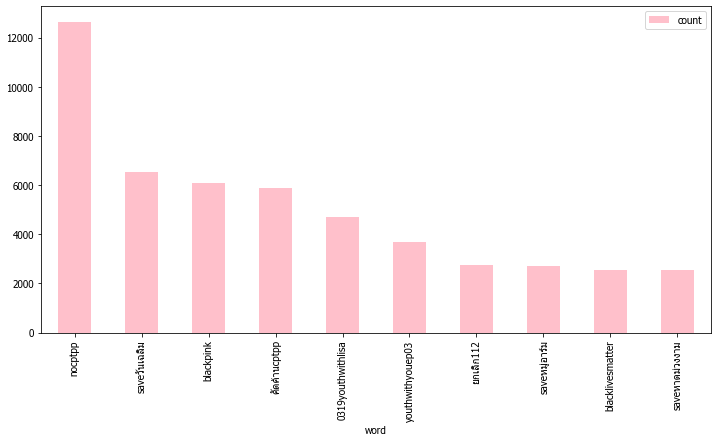

In [28]:
hash_tag_cnt_df.sort_values(by=['count'], ascending=False).set_index('word').head(10).plot(kind="bar",figsize=(12, 6) , color = 'pink')

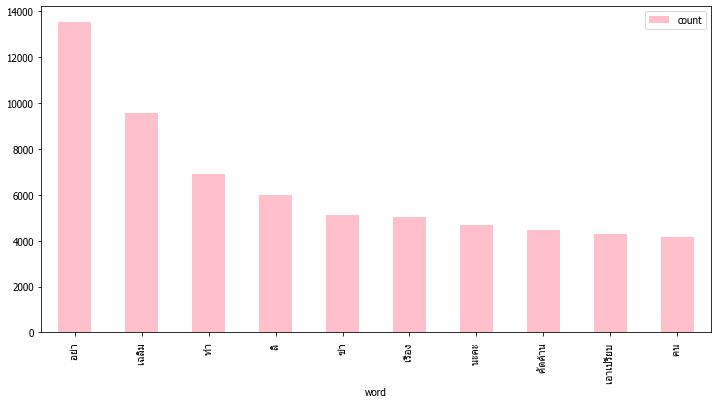

In [27]:
keyword_df2.sort_values(by=['count'], ascending=False).set_index('word').head(10).plot(kind="bar",figsize=(12, 6) , color = 'pink')

In [25]:
plt.rcParams['font.family'] = 'Tahoma'

In [26]:
keyword_df2.sort_values(by=['time'])

KeyError: 'time'